In [119]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [120]:
import os
import random
from pathlib import Path
import shutil
import pandas as pd

In [121]:
#VAE architecture and paramteres
kernels = 2
strides = 2
latent_dim = 28
filters = [32, 64, 128, 224, 512]
input_shape = (224, 224, 3)
last_conv_dim = int(input_shape[0] / (2 ** len(filters)))
b_norm = 3
#Batch Norm
epsilon = 1e-5
#spatial Classifier
num_classes = 4
#dataset
ham_dataset_dir = 'ham_minified'
batch_size = 48
seed = 42
#define early stopping paramter
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

In [122]:
ham_dataset_dir = 'ham_minified'
nv_source_dir = 'nv_src'
nv_test_num = 200
nv_gen_num = 0
batch_size = 48
seed = 42

### Combine True and Synthetic Data

In [123]:
images = list(os.walk(ham_dataset_dir + '/nv'))[0][2]
for image_to_delete in images:
    path = Path(f'{ham_dataset_dir}/nv/{image_to_delete}')
    path.unlink(missing_ok=False)

In [124]:
images = list(os.walk(nv_source_dir + '/nv_true'))[0][2]
nv_images = random.sample(images, nv_test_num)
for true_image in nv_images:
    shutil.copy(nv_source_dir + '/nv_true/' + true_image, ham_dataset_dir + '/nv/' + true_image)

In [125]:
images = list(os.walk(nv_source_dir + '/gen_data'))[0][2]
gen_images = random.sample(images, nv_gen_num)
for gen_image in gen_images:
    shutil.copy(nv_source_dir + '/gen_data/' + gen_image, ham_dataset_dir + '/nv/' + gen_image)

### Data Processing & Class Weights

In [126]:
#load and split datatse
train_ds = keras.preprocessing.image_dataset_from_directory(ham_dataset_dir, validation_split=0.3, color_mode='rgb',
                                                          labels='inferred', label_mode='categorical', shuffle=True, subset='validation', image_size=(224, 224),
                                                          batch_size=batch_size, seed=seed)

val_ds = keras.preprocessing.image_dataset_from_directory(ham_dataset_dir, validation_split=0.3, color_mode='rgb',
                                                          labels='inferred', label_mode='categorical', shuffle=True, subset='validation', image_size=(224, 224),
                                                          batch_size=batch_size, seed=seed)

Found 2926 files belonging to 4 classes.
Using 877 files for validation.
Found 2926 files belonging to 4 classes.
Using 877 files for validation.


In [127]:
classes = train_ds.class_names
train_ds_single_batch = keras.preprocessing.image_dataset_from_directory(ham_dataset_dir, validation_split=0.3, color_mode='rgb',
                                                     labels='inferred', shuffle=True, subset='training', image_size=(224, 224),
                                                     batch_size=1, seed=seed)

Found 2926 files belonging to 4 classes.
Using 2049 files for training.


In [128]:
y = np.array([label.numpy()[0] for _, label in train_ds_single_batch])
class_weights_list = compute_class_weight('balanced', classes=np.unique(y), y=y)
print(class_weights_list)
class_weights = {}

for i in range(len(class_weights_list)):
    class_weights[i] = class_weights_list[i]

[1.40728022 0.66439689 0.65926641 3.73905109]


In [129]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [130]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 10
Number of test batches: 9


In [131]:
#scale immages
rescale = keras.layers.experimental.preprocessing.Rescaling(scale=1.0 / 255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

In [132]:
#autotune dataset
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

### Define Model

In [133]:
#define the neural network
model = Sequential()
for conv_filter in filters:
    model.add(keras.layers.Conv2D(conv_filter, 3, strides=2, padding='same', input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), activation='relu'))
model.add(keras.layers.Dense(num_classes, activation='softmax'))

#print summary of the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 batch_normalization_25 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  (None, 112, 112, 32)      0         
                                                                 
 conv2d_26 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 batch_normalization_26 (Bat  (None, 56, 56, 64)       256       
 chNormalization)                                                
                                                                 
 activation_26 (Activation)  (None, 56, 56, 64)       

In [134]:
#optimize the model with using Adam
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

### Fit Model

In [ ]:
#fit the validation data to the model
history = model.fit(train_ds, validation_data=val_ds, epochs=50, class_weight=class_weights)

Epoch 1/50
19/19 [==============================] - 2s 85ms/step - loss: 3.0193 - accuracy: 0.3261 - val_loss: 1.5558 - val_accuracy: 0.1753
Epoch 2/50
19/19 [==============================] - 2s 77ms/step - loss: 1.2731 - accuracy: 0.4196 - val_loss: 1.7052 - val_accuracy: 0.1618
Epoch 3/50
19/19 [==============================] - 2s 77ms/step - loss: 1.0929 - accuracy: 0.5257 - val_loss: 1.8984 - val_accuracy: 0.1843
Epoch 4/50
19/19 [==============================] - 2s 77ms/step - loss: 1.0375 - accuracy: 0.5450 - val_loss: 2.1706 - val_accuracy: 0.1506
Epoch 5/50
19/19 [==============================] - 2s 78ms/step - loss: 0.9796 - accuracy: 0.5929 - val_loss: 2.5525 - val_accuracy: 0.1528
Epoch 6/50
19/19 [==============================] - 2s 80ms/step - loss: 0.8904 - accuracy: 0.6192 - val_loss: 2.1513 - val_accuracy: 0.1528
Epoch 7/50
19/19 [==============================] - 2s 81ms/step - loss: 0.8441 - accuracy: 0.6613 - val_loss: 2.4455 - val_accuracy: 0.1775
Epoch 8/50
19

In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

### Evaluation

In [110]:
test_list = list(test_ds)

In [111]:
preds = []
labels = []

for batch_num in range(len(test_list)):
    image_batch, label_batch = test_list[batch_num]
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()
    this_pred = model.predict_on_batch(image_batch)
    this_classes = np.argmax(this_pred, axis=1)
    
    pred = tf.keras.utils.to_categorical(this_classes, num_classes=4)
    
    y_test_non_category = [ np.argmax(t) for t in label_batch ]
    y_predict_non_category = [ np.argmax(t) for t in pred ]
    
    labels.extend(y_test_non_category)
    preds.extend(y_predict_non_category)

In [112]:
label_names = sorted(os.listdir(ham_dataset_dir))

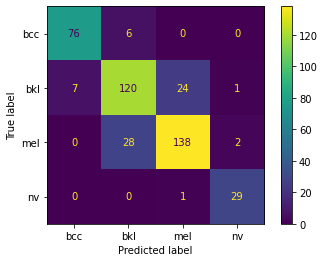

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mat = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=label_names)
disp.plot()
plt.savefig('plots/cnn_da_ft_confmat_nv_' + str(nv_test_num) + '_gen_' + str(nv_gen_num) + '.pdf')

### Precision Recall Metrics

In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [115]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(labels, preds)))

print('Micro Precision: {:.2f}'.format(precision_score(labels, preds, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(labels, preds, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(labels, preds, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(labels, preds, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(labels, preds, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(labels, preds, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(labels, preds, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(labels, preds, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(labels, preds, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(labels, preds, target_names=label_names))


Accuracy: 0.84

Micro Precision: 0.84
Micro Recall: 0.84
Micro F1-score: 0.84

Macro Precision: 0.86
Macro Recall: 0.88
Macro F1-score: 0.87

Weighted Precision: 0.84
Weighted Recall: 0.84
Weighted F1-score: 0.84

Classification Report

              precision    recall  f1-score   support

         bcc       0.92      0.93      0.92        82
         bkl       0.78      0.79      0.78       152
         mel       0.85      0.82      0.83       168
          nv       0.91      0.97      0.94        30

    accuracy                           0.84       432
   macro avg       0.86      0.88      0.87       432
weighted avg       0.84      0.84      0.84       432



In [116]:
report_dict = classification_report(labels, preds, target_names=label_names, output_dict=True)
report_data = pd.DataFrame(report_dict)
report_data.to_csv('reports/cnn_da_ft_report_nv_'+ str(nv_test_num) + '_gen_' + str(nv_gen_num) + '.csv')

In [117]:
report = pd.read_csv('reports/cnn_da_ft_report_nv_'+ str(nv_test_num) + '_gen_' + str(nv_gen_num) + '.csv')

In [118]:
print(report)

  Unnamed: 0        bcc         bkl         mel         nv  accuracy  \
0  precision   0.915663    0.779221    0.846626   0.906250  0.840278   
1     recall   0.926829    0.789474    0.821429   0.966667  0.840278   
2   f1-score   0.921212    0.784314    0.833837   0.935484  0.840278   
3    support  82.000000  152.000000  168.000000  30.000000  0.840278   

    macro avg  weighted avg  
0    0.861940      0.840154  
1    0.876100      0.840278  
2    0.868712      0.840056  
3  432.000000    432.000000  
